In [1]:
import numpy as np
from os import path
import pandas as pd
from random import choice, shuffle

from ga4stpg.graph import ReaderORLibrary
from ga4stpg.condition import BestKnownReached, Stagnation
from ga4stpg.customevol import GeneticEvolution as Evolution
from ga4stpg.customevol import GeneticPopulation as GPopulation
from ga4stpg.graph.reader import read_problem
from ga4stpg.normalization import normalize
from ga4stpg.selector import roullete
from ga4stpg.tracker import DataTracker
from ga4stpg.util import STEIN_B, display, update_best, update_generation

from ga4stpg.tree.evaluation import EvaluateTreeGraph
from ga4stpg.tree.generate import GenerateBasedPrimRST
from ga4stpg.tree.mutate import ReplaceByRandomEdge, PrimBasedMutation, Prunning
from ga4stpg.tree.kruskalpartitioning import KruskalBasedPartitioning

In [2]:
input_file = 'steinb18.txt'

filename = path.join('..', '..', 'ppgi-stpg-gpx', 'datasets','ORLibrary', input_file)
print(filename)

assert path.exists(filename)

reader = ReaderORLibrary()

stpg = reader.parser(filename)

..\..\ppgi-stpg-gpx\datasets\ORLibrary\steinb18.txt


In [3]:
crossover = KruskalBasedPartitioning(stpg)
evaluator = EvaluateTreeGraph(stpg)
generator = GenerateBasedPrimRST(stpg)
replace  = ReplaceByRandomEdge(stpg)
mst_mutation = PrimBasedMutation(stpg)
prunning = Prunning(stpg)

In [4]:
population = (GPopulation(
        chromosomes=[ generator() for _ in range(100)],
        eval_function=evaluator,
        maximize=True)
    .evaluate()
    .normalize(norm_function=normalize)
    .callback(update_best))

<AxesSubplot:>

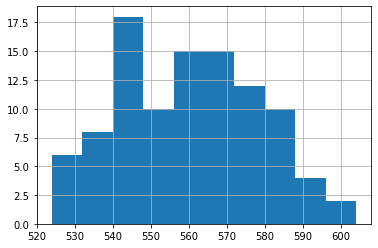

In [5]:
df = pd.Series([p.cost for p in population])
df.hist()

In [6]:
data = []
for i in range(10):
    print(f"trial {i}", end=' ')
    for j in range(100):
        population = (population
                        .select(selection_func=roullete)
                        .crossover(combiner=crossover)
                        .mutate(mutate_function=replace, probability=0.2)
                        .mutate(mutate_function=mst_mutation, probability=0.2)
                        .mutate(mutate_function=prunning, probability=0.2)
                        .evaluate()
                        .normalize(norm_function=normalize)
                        .callback(update_best)
                        .callback(update_generation)
                        )
    
    df = pd.Series([p.cost for p in population])
    data.append(df)

trial 0 trial 1 trial 2 trial 3 trial 4 trial 5 trial 6 trial 7 trial 8 trial 9 

In [7]:
best = population.documented_best

In [8]:
best.cost

205

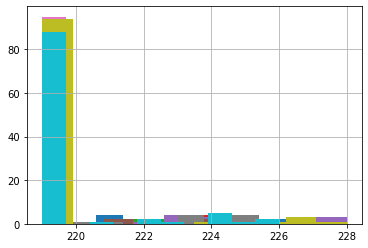

In [9]:
for i in range(10):
    data[i].hist()